In [1]:
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C

import efficientnet.tfkeras as efn

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ImageDataAugmentor.image_data_augmentor import *
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

import albumentations
import PIL

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    #plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [3]:
EPOCHS               = 10
BATCH_SIZE           = 32
LR                   = 1e-3
VAL_SPLIT            = 0.1

CLASS_NUM            = 10
IMG_SIZE             = 128
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE - 10, IMG_SIZE - 10, IMG_CHANNELS)

PATH = './data'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  

In [4]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.Resize(height=IMG_SIZE, width=IMG_SIZE),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.CenterCrop(height=IMG_SIZE-10, width=IMG_SIZE-10),
    albumentations.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05),
    albumentations.GaussianBlur(p=0.1),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1),
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255,
                                 augment = AUGMENTATIONS,
                                 )

In [5]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train/'),      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE-10, IMG_SIZE-10),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train/'),
    target_size=(IMG_SIZE-10, IMG_SIZE-10),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

/home/nkotelevskii/anaconda3/envs/condatf/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 14010 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.


In [6]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
print(len(base_model.layers))

806


# Сперва сделаем Transfer Learning

In [8]:
base_model.trainable = False

In [8]:
# base_model.summary()

In [9]:
# меняем "голову"
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.BatchNormalization())
model.add(L.LeakyReLU(alpha=0.1))
model.add(L.Dropout(rate=0.5))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [10]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=LR), metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 4, 4, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2560)              10240     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                25610     
Total params: 64,133,530
Trainable params: 30,730
Non-trainable params: 64,102,800
_______________________________________

In [12]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [13]:
train_logs = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list,
)

Epoch 1/10
 49/438 [==>...........................] - ETA: 1:44 - loss: 2.2891 - acc: 0.1437
Epoch 00001: saving model to best_model.hdf5
438/438 [==============================] - 98s 224ms/step - loss: 2.8688 - acc: 0.1453 - val_loss: 2.2891 - val_acc: 0.1437
Epoch 2/10
 49/438 [==>...........................] - ETA: 1:25 - loss: 2.1375 - acc: 0.2139
Epoch 00002: saving model to best_model.hdf5
438/438 [==============================] - 88s 201ms/step - loss: 2.6242 - acc: 0.1771 - val_loss: 2.1375 - val_acc: 0.2139
Epoch 3/10
 49/438 [==>...........................] - ETA: 1:24 - loss: 2.1928 - acc: 0.2268
Epoch 00003: saving model to best_model.hdf5
438/438 [==============================] - 88s 201ms/step - loss: 2.5101 - acc: 0.1951 - val_loss: 2.1928 - val_acc: 0.2268
Epoch 4/10
 49/438 [==>...........................] - ETA: 1:24 - loss: 2.0840 - acc: 0.2474
Epoch 00004: saving model to best_model.hdf5
438/438 [==============================] - 86s 197ms/step - loss: 2.4726 - a

In [14]:
# model.load_weights('best_model.hdf5')

In [15]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 8s 168ms/step - loss: 2.0612 - acc: 0.2738
Accuracy: 27.38%


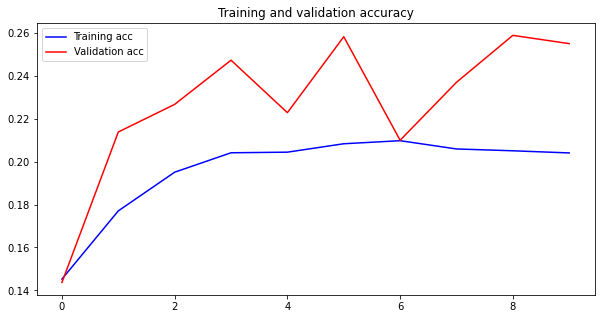

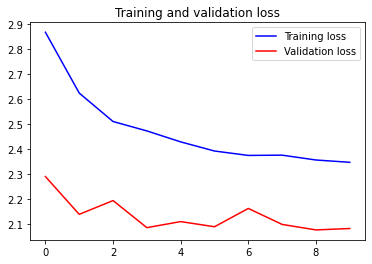

In [16]:
plot_history(train_logs)

# А затем сделаем Fine Tuning

### Сперва с половиной слоёв, обученных на ImageNet

In [17]:
BATCH_SIZE           = 16

In [18]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2

# Заморозим все слои перед тонкой надстройкой
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [19]:
# уменьшим LR
LR = 0.0001
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=LR), metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 4, 4, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2560)              10240     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                25610     
Total params: 64,133,530
Trainable params: 59,113,762
Non-trainable params: 5,019,768
____________________________________

In [21]:
train_logs = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
 49/438 [==>...........................] - ETA: 1:46 - loss: 1.5050 - acc: 0.4697
Epoch 00001: saving model to best_model.hdf5
438/438 [==============================] - 120s 275ms/step - loss: 1.8817 - acc: 0.3370 - val_loss: 1.5050 - val_acc: 0.4697
Epoch 2/10
 49/438 [==>...........................] - ETA: 1:26 - loss: 1.2129 - acc: 0.5754
Epoch 00002: saving model to best_model.hdf5
438/438 [==============================] - 94s 215ms/step - loss: 1.3230 - acc: 0.5378 - val_loss: 1.2129 - val_acc: 0.5754
Epoch 3/10
 49/438 [==>...........................] - ETA: 1:26 - loss: 1.0287 - acc: 0.6366
Epoch 00003: saving model to best_model.hdf5
438/438 [==============================] - 95s 216ms/step - loss: 1.0240 - acc: 0.6420 - val_loss: 1.0287 - val_acc: 0.6366
Epoch 4/10
 49/438 [==>...........................] - ETA: 1:25 - loss: 0.8425 - acc: 0.6927
Epoch 00004: saving model to best_model.hdf5
438/438 [==============================] - 95s 217ms/step - loss: 0.8270 - 

In [22]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 9s 181ms/step - loss: 0.5855 - acc: 0.8035
Accuracy: 80.35%


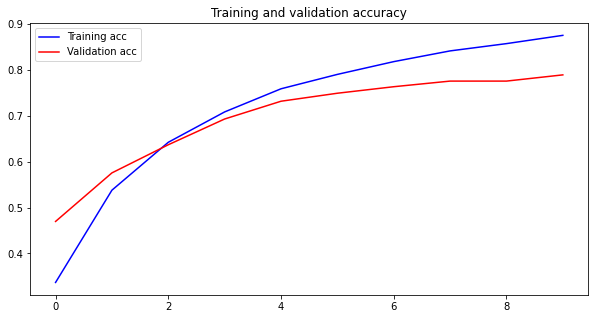

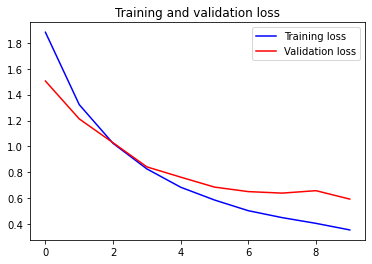

In [23]:
plot_history(train_logs)

### А затем и на всей модели.

In [24]:
BATCH_SIZE           = 8

In [25]:
for layer in base_model.layers:
    layer.trainable = True
for layer in model.layers:
    layer.trainable = True

In [26]:
LR = 0.00001
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=LR), metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 4, 4, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2560)              10240     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                25610     
Total params: 64,133,530
Trainable params: 63,817,690
Non-trainable params: 315,840
______________________________________

In [28]:
train_logs = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
 49/438 [==>...........................] - ETA: 1:49 - loss: 0.3784 - acc: 0.8731
Epoch 00001: saving model to best_model.hdf5
438/438 [==============================] - 204s 466ms/step - loss: 0.2933 - acc: 0.8907 - val_loss: 0.3784 - val_acc: 0.8731
Epoch 2/10
 49/438 [==>...........................] - ETA: 1:25 - loss: 0.3651 - acc: 0.8756
Epoch 00002: saving model to best_model.hdf5
438/438 [==============================] - 157s 357ms/step - loss: 0.2617 - acc: 0.9067 - val_loss: 0.3651 - val_acc: 0.8756
Epoch 3/10
 49/438 [==>...........................] - ETA: 1:24 - loss: 0.3412 - acc: 0.8834
Epoch 00003: saving model to best_model.hdf5
438/438 [==============================] - 156s 357ms/step - loss: 0.2595 - acc: 0.9096 - val_loss: 0.3412 - val_acc: 0.8834
Epoch 4/10
 49/438 [==>...........................] - ETA: 1:23 - loss: 0.3436 - acc: 0.8840- ETA
Epoch 00004: saving model to best_model.hdf5
438/438 [==============================] - 156s 356ms/step - loss: 0

In [29]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 9s 174ms/step - loss: 0.3136 - acc: 0.8976
Accuracy: 89.76%


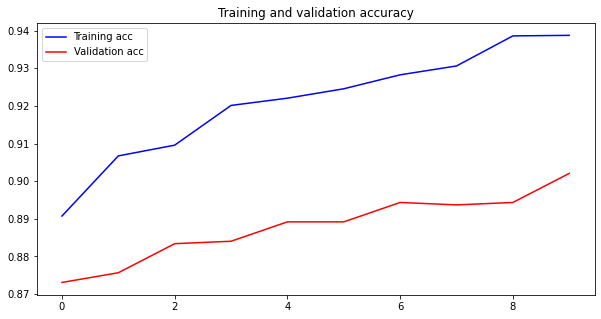

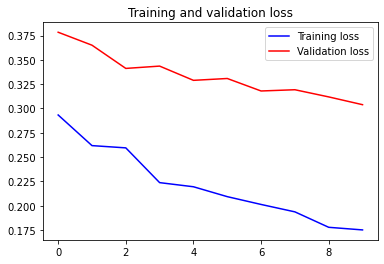

In [30]:
plot_history(train_logs)